In [48]:
# !pip install numpy
# !pip install scipy
# !pip install pandas
# !pip install matplotlib

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.stats import linregress
from scipy import constants as const

### Предобработка

In [50]:
data = pd.read_csv(r"data_main.csv")
constant_background = 0.6798
data.N -= constant_background
data.head()

,Current,N
0,0.20,0.3702
1,0.31,0.5402
2,0.41,0.7902
3,0.50,0.7802
4,0.60,0.6702


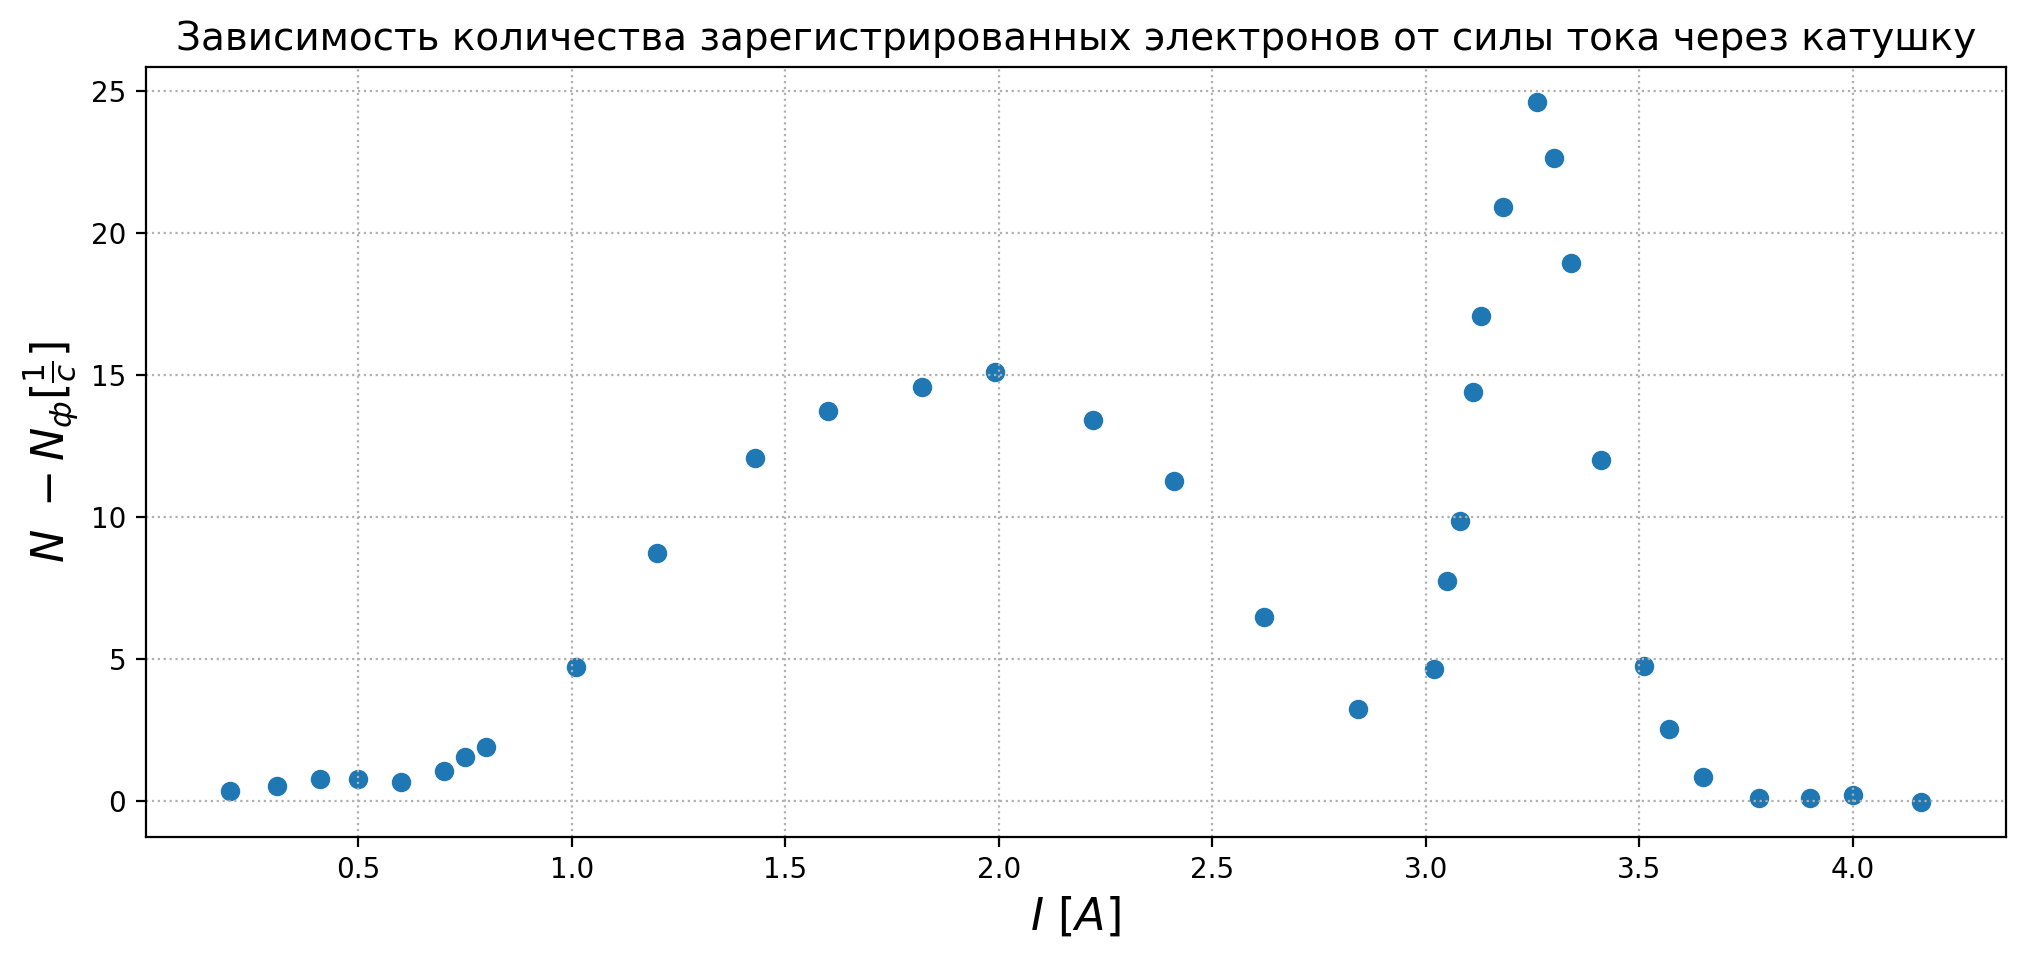

In [51]:
plt.figure(figsize = (12, 5), dpi = 200)
plt.scatter(data.Current, data.N)
plt.grid(ls = ':')
plt.xlabel("$I \ [A]$", fontsize = 16)
plt.ylabel(r"$N \ - N_{ф} [\frac{1}{c}]$", fontsize = 16)
plt.title("Зависимость количества зарегистрированных электронов от силы тока через катушку",
          fontsize = 14);

### Калибровка спектрометра

Импульс прилетающих в камеру электронов линейно зависит от силы тока: $p_{e} = k I$. Коэффициент $k$ найдём из условия что конверсионные электроны имеют энергию $634 кЭВ$.

Для интерполяции полученной зависимости будем использовать данные полученные при регистрации неконверсионных электронов. Методом наименьших квадратов найдём максимальную энергию электронов в формуле:
$$
N(p) = p^{2} \cdot (E_{e} - E)^{2}
$$

Интерполяцию буду проводить в диапазоне $J \in [0, 2.8] \cup [3.5, 4.5]$

In [52]:
conversion_current = data.Current[np.argmax(data.N)] #сила тока при котрой улавливаются электроны конверсии
k = 634 / (const.c * conversion_current)
p = k * data.Current
energy = np.sqrt(np.power(p * const.c, 2) + np.power(const.electron_mass, 2) * np.power(const.c, 4))
p_line = np.linspace(np.min(p), np.max(p) / 2, 1000)
energy_line = np.sqrt(np.power(p_line * const.c, 2) + np.power(const.electron_mass, 2) * np.power(const.c, 4))
no_conv_area = (data.Current < 3) * (data.Current > 1)

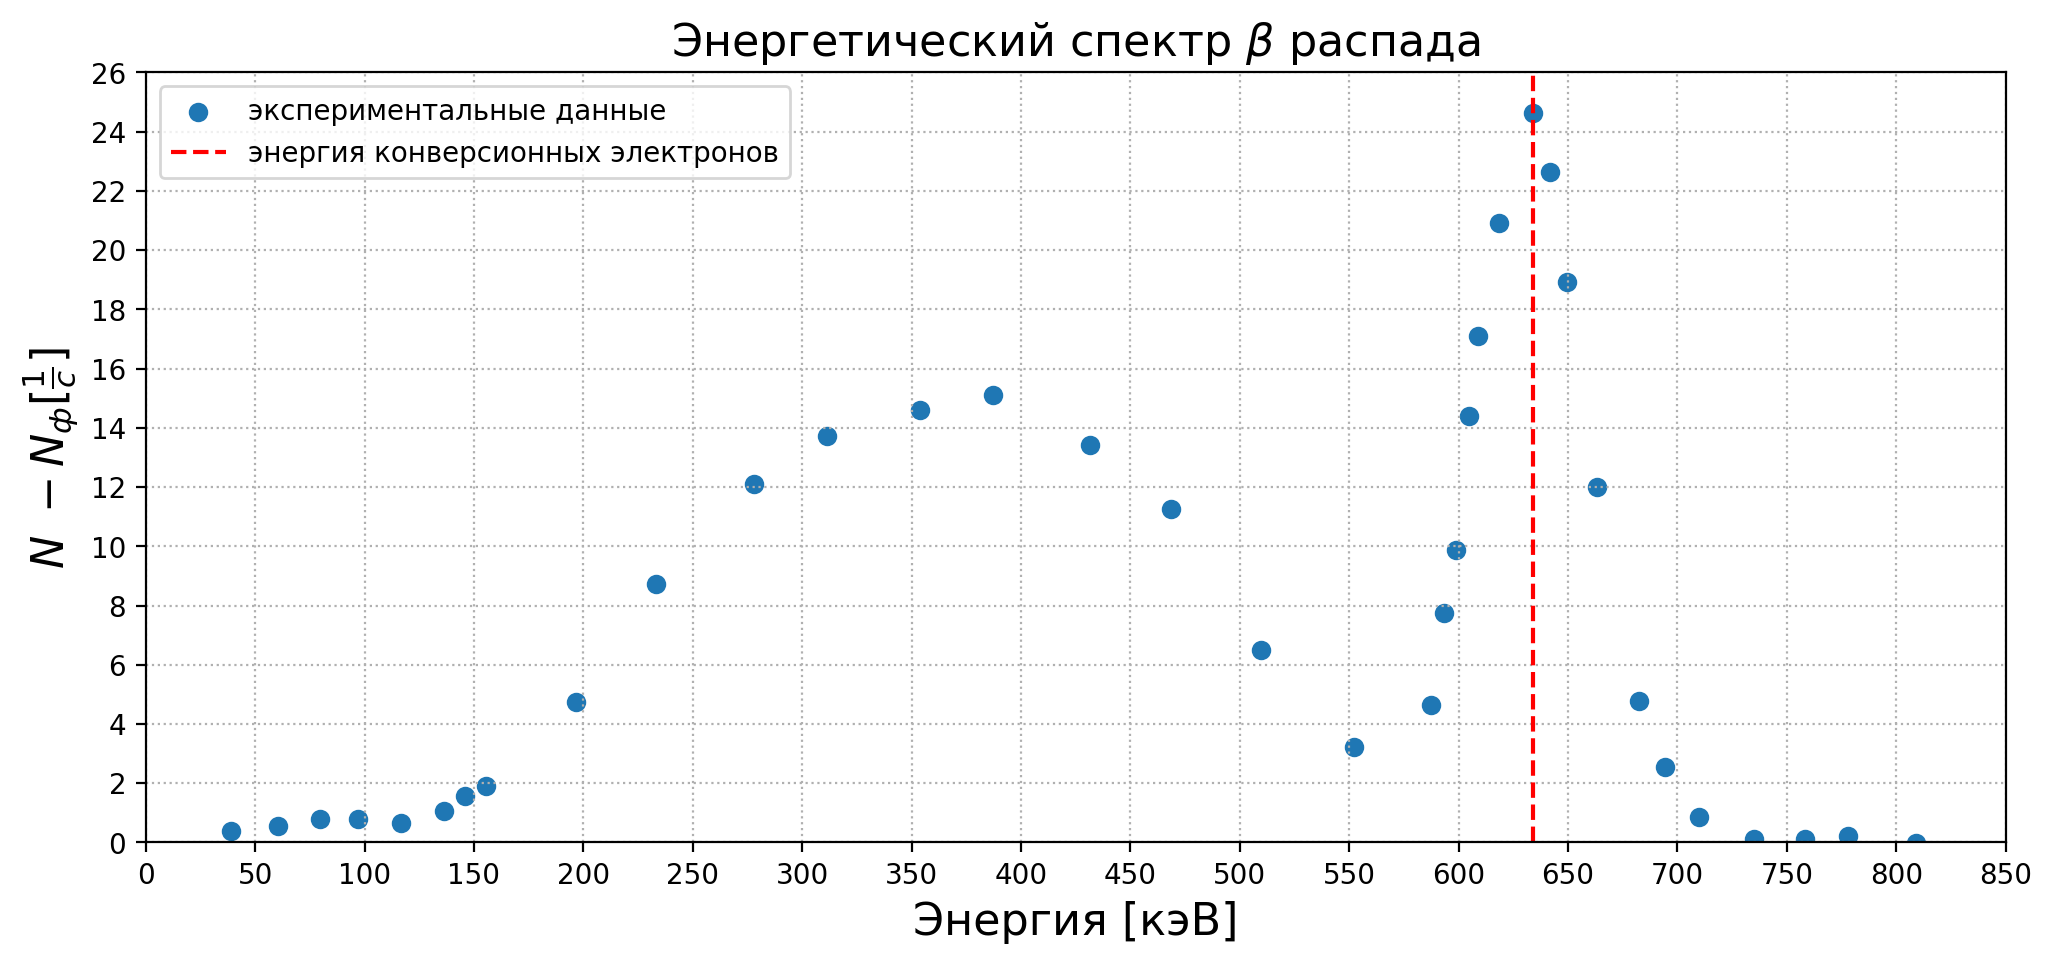

In [53]:
plt.figure(figsize = (12, 5), dpi = 200)
plt.scatter(energy, 
            data.N,
            label = 'экспериментальные данные')
plt.axvline(634, linestyle = '--', color = 'red', label = 'энергия конверсионных электронов')
# plt.plot(energy_line, const.c * np.power(p_line, 2) * np.power(700 - energy_line, 2))
plt.xlabel("Энергия [кэВ]", fontsize = 16)
plt.ylabel(r"$N \ - N_{ф} [\frac{1}{c}]$", fontsize = 16)
plt.title(r"Энергетический спектр $\beta$ распада", fontsize = 16)
plt.grid(ls = ':')
plt.xticks(np.arange(0, 900 + 50, 50))
plt.yticks(np.arange(0, 27, 2))
plt.xlim(0, 850)
plt.ylim(0, 26)
plt.legend();

In [54]:
fermi = np.sqrt(np.abs(data.N)) / (const.c * p)
MNK = linregress(energy[no_conv_area], fermi[no_conv_area])
x_line = np.linspace(0, 850, 1000)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


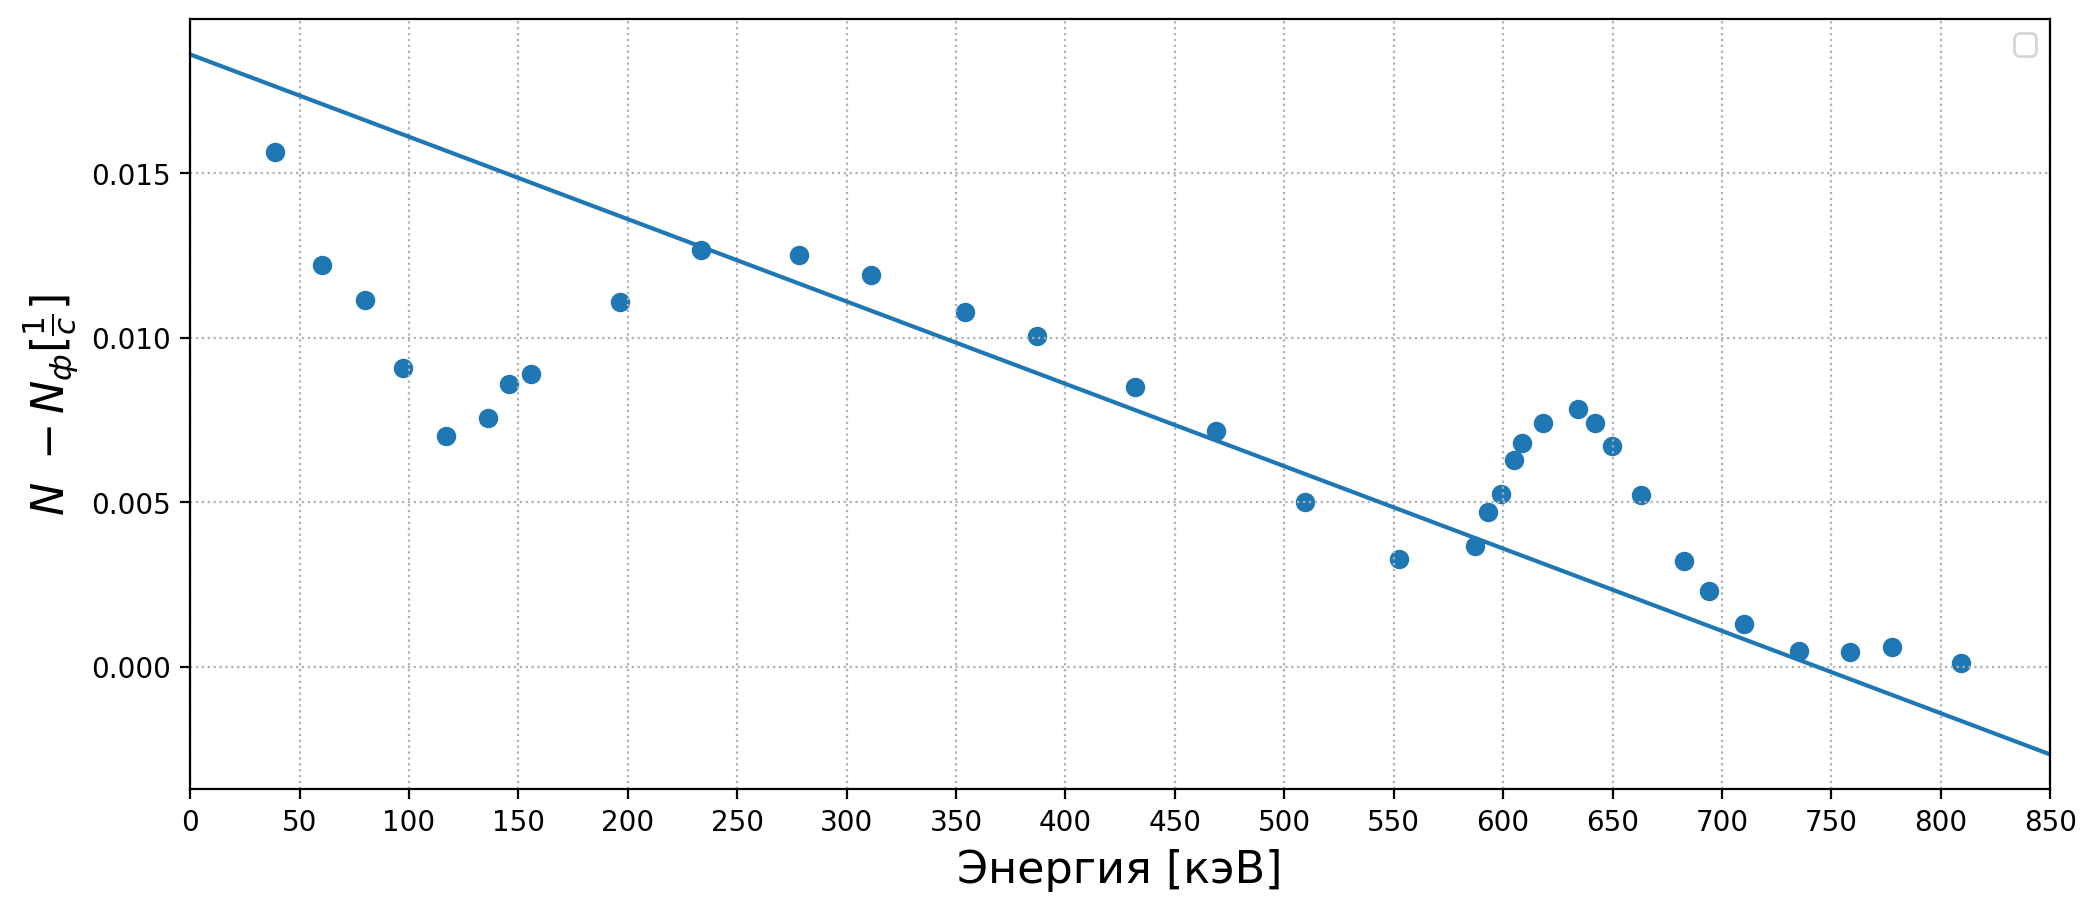

In [55]:
plt.figure(figsize = (12, 5), dpi = 200)
plt.scatter(energy, fermi)
plt.plot(x_line, MNK.slope * x_line + MNK.intercept)

plt.xlabel("Энергия [кэВ]", fontsize = 16)
plt.ylabel(r"$N \ - N_{ф} [\frac{1}{c}]$", fontsize = 16)
plt.grid(ls = ':')
plt.xticks(np.arange(0, 900 + 50, 50))
plt.xlim(0, 850)
plt.legend();